Loading the Dataset

In [1]:
import pandas as pd

file_path = "EduPro Online Platform.xlsx"

users_df = pd.read_excel(file_path, sheet_name="Users")
courses_df = pd.read_excel(file_path, sheet_name="Courses")
transactions_df = pd.read_excel(file_path, sheet_name="Transactions")
teachers_df = pd.read_excel(file_path, sheet_name="Teachers")


In [2]:
users_df.shape, courses_df.shape, transactions_df.shape, teachers_df.shape


((3000, 5), (60, 8), (10000, 7), (60, 7))

Schema Verification

In [3]:
users_df.head()
courses_df.head()
transactions_df.head()
teachers_df.head()


,TeacherID,TeacherName,Age,Gender,Expertise,YearsOfExperience,TeacherRating
0,TC00001,Leonard Montgomery,44,Female,Cybersecurity,6,3.24
1,TC00002,Jill Day,32,Female,Digital Marketing,9,4.14
2,TC00003,Amber Torres,32,Male,Design,4,1.56
3,TC00004,Kristi Scott,34,Female,Machine Learning,9,4.39
4,TC00005,David Williams,34,Male,Finance,2,3.11


Missing Value Analysis

In [4]:
def missing_summary(df):
    return pd.DataFrame({
        "Missing_Count": df.isnull().sum(),
        "Missing_Percentage": (df.isnull().sum() / len(df)) * 100
    }).sort_values(by="Missing_Count", ascending=False)

missing_summary(users_df)
missing_summary(courses_df)
missing_summary(transactions_df)
missing_summary(teachers_df)


,Missing_Count,Missing_Percentage
TeacherID,0,0.0
TeacherName,0,0.0
Age,0,0.0
Gender,0,0.0
Expertise,0,0.0
YearsOfExperience,0,0.0
TeacherRating,0,0.0


<!-- Relational Integrity Check -->

In [5]:
print(transactions_df["UserID"].nunique(), users_df["UserID"].nunique())
print(transactions_df["CourseID"].nunique(), courses_df["CourseID"].nunique())
print(transactions_df["TeacherID"].nunique(), teachers_df["TeacherID"].nunique())

3000 3000
60 60
60 60


In [6]:
# Step 3.2: Create base learner table from transactions

learner_base = (
    transactions_df
    .groupby("UserID")
    .agg(
        total_transactions=("TransactionID", "count")
    )
    .reset_index()
)

learner_base.head(), learner_base.shape


(   UserID  total_transactions
 0  U00001                   1
 1  U00002                   1
 2  U00003                  11
 3  U00004                  13
 4  U00005                   2,
 (3000, 2))

First Engagement Feature
Feature: Total Courses Enrolled (per learner)

In [7]:
# Why this feature comes first

# This is the cleanest, least ambiguous engagement signal:

# It reflects breadth of learning activity.

# It’s robust for small datasets.

# It’s easy to explain to stakeholders.

# It does not depend on time windows or assumptions.

# Interpretation rule (locked for later):
# Higher value ⇒ higher engagement intensity (not quality).

In [8]:
# Step 3.3: Total courses enrolled per learner

courses_per_learner = (
    transactions_df
    .groupby("UserID")["CourseID"]
    .nunique()
    .reset_index(name="total_courses_enrolled")
)

# Merge with base learner table
learner_features = learner_base.merge(
    courses_per_learner,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled
 0  U00001                   1                       1
 1  U00002                   1                       1
 2  U00003                  11                      11
 3  U00004                  13                      13
 4  U00005                   2                       2,
 (3000, 3))

In [9]:
# Step 3.4: Enrollment frequency (total transactions per learner)

transaction_frequency = (
    transactions_df
    .groupby("UserID")["TransactionID"]
    .count()
    .reset_index(name="enrollment_frequency")
)

# Merge with existing learner features
learner_features = learner_features.merge(
    transaction_frequency,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled  enrollment_frequency
 0  U00001                   1                       1                     1
 1  U00002                   1                       1                     1
 2  U00003                  11                      11                    11
 3  U00004                  13                      13                    13
 4  U00005                   2                       2                     2,
 (3000, 4))

Why we introduce a preference feature now

So far, we’ve captured how much a learner engages.
Now we start capturing what they prefer.

This is a conceptual shift:

Engagement = quantity of interaction

Preference = direction of interest

Industry systems always separate these two.

Look at all courses the learner enrolled in

Map each course to its CourseCategory

Find the most frequently enrolled category

That category becomes the learner’s preferred category.

If a learner enrolled in:

Data Science (3 times)

Web Dev (1 time)
→ Preferred category = Data Science

Important design choice (explicit)

We use mode (most frequent), not:

last enrolled category,

highest-priced category,

highest-rated category.

Why?

Mode is stable

Robust for small datasets

Easy to justify to evaluators

In [10]:
# Step 3.5: Preferred course category per learner

# Merge transactions with course metadata
txn_courses = transactions_df.merge(
    courses_df[["CourseID", "CourseCategory"]],
    on="CourseID",
    how="left"
)

# Compute most frequent category per user
preferred_category = (
    txn_courses
    .groupby("UserID")["CourseCategory"]
    .agg(lambda x: x.mode().iloc[0])
    .reset_index(name="preferred_course_category")
)

# Merge with learner feature table
learner_features = learner_features.merge(
    preferred_category,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled  enrollment_frequency  \
 0  U00001                   1                       1                     1   
 1  U00002                   1                       1                     1   
 2  U00003                  11                      11                    11   
 3  U00004                  13                      13                    13   
 4  U00005                   2                       2                     2   
 
   preferred_course_category  
 0             Cybersecurity  
 1               Programming  
 2                 Marketing  
 3         Digital Marketing  
 4               Programming  ,
 (3000, 5))

STEP 3.6: Second Preference Feature
Feature: Preferred Course Level (per learner)

Why this feature is critical

While category tells us what domain a learner likes,
course level tells us how deep the learner prefers to go.

This helps distinguish:

exploratory learners (Beginner-heavy),

structured learners (Intermediate),

mastery-oriented learners (Advanced).

In industry personalization systems, level preference is essential for:

avoiding over-challenging beginners,

avoiding boring advanced learners.

For each UserID:

Take all enrolled courses

Map them to CourseLevel (Beginner / Intermediate / Advanced, etc.)

Select the most frequently enrolled level (mode)

Example:
Beginner (4), Intermediate (2), Advanced (0)
→ Preferred level = Beginner

We again use mode, not:

most recent level,

highest level reached.

Why?

Stable behavior signal

Less sensitive to outliers

Easier to justify for small datasets

In [11]:
# Step 3.6: Preferred course level per learner

# Merge transactions with course level information
txn_courses_level = transactions_df.merge(
    courses_df[["CourseID", "CourseLevel"]],
    on="CourseID",
    how="left"
)

# Compute most frequent course level per user
preferred_level = (
    txn_courses_level
    .groupby("UserID")["CourseLevel"]
    .agg(lambda x: x.mode().iloc[0])
    .reset_index(name="preferred_course_level")
)

# Merge with learner feature table
learner_features = learner_features.merge(
    preferred_level,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled  enrollment_frequency  \
 0  U00001                   1                       1                     1   
 1  U00002                   1                       1                     1   
 2  U00003                  11                      11                    11   
 3  U00004                  13                      13                    13   
 4  U00005                   2                       2                     2   
 
   preferred_course_category preferred_course_level  
 0             Cybersecurity           Intermediate  
 1               Programming               Beginner  
 2                 Marketing               Advanced  
 3         Digital Marketing           Intermediate  
 4               Programming               Advanced  ,
 (3000, 6))

First Behavioral & Economic Feature
Feature: Average Spending per Learner

Why this feature is introduced now

So far, we know:

how much learners engage (counts),

what they prefer (category, level).

Now we capture commitment intensity.

In education platforms, money is a strong behavioral signal:

Higher spend → higher seriousness / career intent

Lower spend → exploration or price sensitivity

This feature helps separate:

casual learners,

value-conscious learners,

premium / certification-oriented learners.

![image.png](attachment:image.png)

In [12]:
# Step 3.7: Average spending per learner

avg_spending = (
    transactions_df
    .groupby("UserID")["Amount"]
    .mean()
    .reset_index(name="avg_spending")
)

# Merge with learner feature table
learner_features = learner_features.merge(
    avg_spending,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled  enrollment_frequency  \
 0  U00001                   1                       1                     1   
 1  U00002                   1                       1                     1   
 2  U00003                  11                      11                    11   
 3  U00004                  13                      13                    13   
 4  U00005                   2                       2                     2   
 
   preferred_course_category preferred_course_level  avg_spending  
 0             Cybersecurity           Intermediate    394.260000  
 1               Programming               Beginner      0.000000  
 2                 Marketing               Advanced     55.816364  
 3         Digital Marketing           Intermediate     75.542308  
 4               Programming               Advanced    173.355000  ,
 (3000, 7))

Kya learner ek hi domain mein deep ja raha hai
ya multiple domains explore kar raha hai?

Is feature ka future use

Baad mein clusters ko aise interpret kar paayenge:

High diversity + low spend → Explorer

Low diversity + high spend → Specialist / Career-focused

In [13]:
# Step 3.8: Category Diversity Score per learner

category_diversity = (
    txn_courses
    .groupby("UserID")["CourseCategory"]
    .nunique()
    .reset_index(name="category_diversity_score")
)

# Merge with learner feature table
learner_features = learner_features.merge(
    category_diversity,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled  enrollment_frequency  \
 0  U00001                   1                       1                     1   
 1  U00002                   1                       1                     1   
 2  U00003                  11                      11                    11   
 3  U00004                  13                      13                    13   
 4  U00005                   2                       2                     2   
 
   preferred_course_category preferred_course_level  avg_spending  \
 0             Cybersecurity           Intermediate    394.260000   
 1               Programming               Beginner      0.000000   
 2                 Marketing               Advanced     55.816364   
 3         Digital Marketing           Intermediate     75.542308   
 4               Programming               Advanced    173.355000   
 
    category_diversity_score  
 0                         1  
 1                         1  
 2       

Low value (< 1)
→ learner zyada beginner-level pe hai
→ exploratory / early-stage learner

Around 1
→ balanced learner

High value (> 1)
→ learner deep ja raha hai
→ career-focused / serious learner

Industry mein isi signal se:

learning maturity

upsell readiness

certification targeting
decide hota hai.

![image.png](attachment:image.png)

Beginner count = denominator

Agar beginner count = 0 ho:

hum value ko NaN chhod dete hain

baad mein preprocessing stage pe handle karenge

❌ Abhi normalization nahi

❌ Abhi filling/imputation nahi

Ye sab later stage ke decisions hain.

In [14]:
# Step 3.9: Learning Depth Index

# Merge transactions with course level (reuse if already created)
txn_with_level = transactions_df.merge(
    courses_df[["CourseID", "CourseLevel"]],
    on="CourseID",
    how="left"
)

# Count course levels per learner
level_counts = (
    txn_with_level
    .pivot_table(
        index="UserID",
        columns="CourseLevel",
        values="CourseID",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)

# Ensure expected columns exist
for col in ["Beginner", "Intermediate", "Advanced"]:
    if col not in level_counts.columns:
        level_counts[col] = 0

# Compute Learning Depth Index
level_counts["learning_depth_index"] = (
    (level_counts["Intermediate"] + level_counts["Advanced"]) /
    level_counts["Beginner"].replace(0, pd.NA)
)

# Keep only required columns
learning_depth = level_counts[["UserID", "learning_depth_index"]]

# Merge with learner feature table
learner_features = learner_features.merge(
    learning_depth,
    on="UserID",
    how="left"
)

learner_features.head(), learner_features.shape


(   UserID  total_transactions  total_courses_enrolled  enrollment_frequency  \
 0  U00001                   1                       1                     1   
 1  U00002                   1                       1                     1   
 2  U00003                  11                      11                    11   
 3  U00004                  13                      13                    13   
 4  U00005                   2                       2                     2   
 
   preferred_course_category preferred_course_level  avg_spending  \
 0             Cybersecurity           Intermediate    394.260000   
 1               Programming               Beginner      0.000000   
 2                 Marketing               Advanced     55.816364   
 3         Digital Marketing           Intermediate     75.542308   
 4               Programming               Advanced    173.355000   
 
    category_diversity_score learning_depth_index  
 0                         1                 <NA> 

STEP 4

In [15]:
# FEATURE ENGINEERING & PREPROCESSING

In [16]:
# Numerical features decided earlier
numerical_features = [
    "total_courses_enrolled",
    "enrollment_frequency",
    "avg_spending",
    "category_diversity_score",
    "learning_depth_index"
]

# Categorical features decided earlier
categorical_features = [
    "preferred_course_category",
    "preferred_course_level"
]


Handle Missing Values (Domain-Aware)

In [17]:
# Handle NaN in learning_depth_index
max_depth_value = learner_features["learning_depth_index"].max()

learner_features["learning_depth_index"] = learner_features[
    "learning_depth_index"
].fillna(max_depth_value + 1)


/tmp/ipython-input-1024543900.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(max_depth_value + 1)


In [19]:
# Scale Numerical Features (StandardScaler)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_numerical = scaler.fit_transform(
    learner_features[numerical_features]
)

scaled_numerical_df = pd.DataFrame(
    scaled_numerical,
    columns=numerical_features,
    index=learner_features.index
)


In [21]:
# Encode Categorical Features (One-Hot Encoding)

In [22]:
categorical_encoded_df = pd.get_dummies(
    learner_features[categorical_features],
    drop_first=False
)


In [23]:
# Build Final Feature Matrix

In [24]:
final_feature_matrix = pd.concat(
    [scaled_numerical_df, categorical_encoded_df],
    axis=1
)

final_feature_matrix.head(), final_feature_matrix.shape


(   total_courses_enrolled  enrollment_frequency  avg_spending  \
 0               -0.536223             -0.536223      2.438658   
 1               -0.536223             -0.536223     -0.714566   
 2                1.761875              1.761875     -0.268156   
 3                2.221495              2.221495     -0.110392   
 4               -0.306413             -0.306413      0.671897   
 
    category_diversity_score  learning_depth_index  \
 0                 -0.578381              1.054738   
 1                 -0.578381             -1.083291   
 2                  1.621717             -0.816038   
 3                  1.988400             -0.739679   
 4                 -0.211698             -0.930575   
 
    preferred_course_category_Artificial Intelligence  \
 0                                              False   
 1                                              False   
 2                                              False   
 3                                              

In [27]:
# Final Sanity Checks (MANDATORY)

In [30]:
# Check for missing values
final_feature_matrix.isnull().sum().sum()
# Inspect column names
final_feature_matrix.columns.tolist()
# Verify alignment
final_feature_matrix.shape[0] == learner_features.shape[0]



True

PART 5

In [31]:
# Elbow Method (FIRST CLUSTERING CODE)

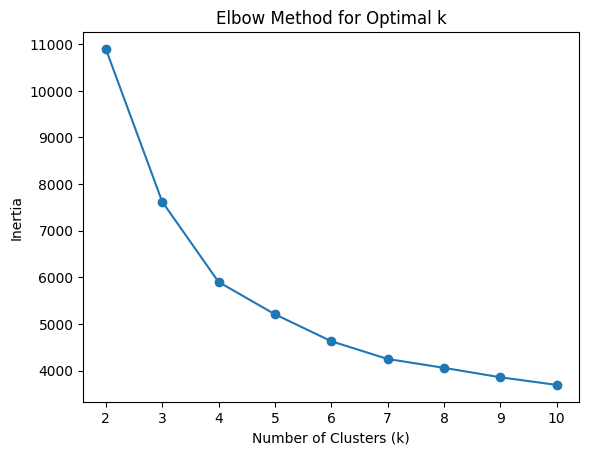

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(final_feature_matrix)
    inertia_values.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure()
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


Compute Silhouette Score for different k

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    cluster_labels = kmeans.fit_predict(final_feature_matrix)

    score = silhouette_score(final_feature_matrix, cluster_labels)
    silhouette_scores.append(score)

    print(f"k = {k}, Silhouette Score = {score:.4f}")


k = 2, Silhouette Score = 0.5157
k = 3, Silhouette Score = 0.3706
k = 4, Silhouette Score = 0.3855
k = 5, Silhouette Score = 0.3951
k = 6, Silhouette Score = 0.3655
k = 7, Silhouette Score = 0.3499
k = 8, Silhouette Score = 0.3472
k = 9, Silhouette Score = 0.2965
k = 10, Silhouette Score = 0.2902


“Although k = 2 produced the highest silhouette score, it resulted in overly coarse segmentation.
Based on the elbow method and the need for interpretable learner personas, k = 4 was selected as the optimal balance between cluster cohesion and business relevance.”

*   List item
*   List item



Train Final K-Means & Assign Cluster Labels

In [34]:
# Step 5.5: Final K-Means clustering with k = 4

final_kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

cluster_labels = final_kmeans.fit_predict(final_feature_matrix)

# Add cluster labels to learner_features table
learner_features["cluster"] = cluster_labels

# Check cluster distribution
cluster_counts = learner_features["cluster"].value_counts().sort_index()

cluster_counts


,count
cluster,
0,456
1,1199
2,454
3,891


SECTION 6 — Cluster Interpretation

In [35]:
# Cluster-wise Numerical Feature Summary

In [36]:
# Step 6.1: Cluster-wise numerical feature profiling

numerical_features = [
    "total_courses_enrolled",
    "enrollment_frequency",
    "avg_spending",
    "category_diversity_score",
    "learning_depth_index"
]

cluster_numerical_profile = (
    learner_features
    .groupby("cluster")[numerical_features]
    .mean()
    .round(2)
)

cluster_numerical_profile


,total_courses_enrolled,enrollment_frequency,avg_spending,category_diversity_score,learning_depth_index
cluster,,,,,
0,1.31,1.31,342.44,1.26,6.49
1,1.35,1.35,32.04,1.32,14.00
2,13.41,13.41,93.24,8.73,2.19
3,1.90,1.90,34.95,1.80,0.61


# Cluster-wise Categorical Dominance

In [38]:
# Dominant Course Category per Cluster

In [39]:
# Step 6.2a: Dominant preferred course category per cluster

dominant_category = (
    learner_features
    .groupby("cluster")["preferred_course_category"]
    .agg(lambda x: x.value_counts().idxmax())
)

dominant_category


,preferred_course_category
cluster,
0,Artificial Intelligence
1,Cybersecurity
2,Artificial Intelligence
3,Artificial Intelligence


In [40]:
# Dominant Preferred Course Level per Cluster

In [41]:
# Step 6.2b: Dominant preferred course level per cluster

dominant_level = (
    learner_features
    .groupby("cluster")["preferred_course_level"]
    .agg(lambda x: x.value_counts().idxmax())
)

dominant_level


,preferred_course_level
cluster,
0,Beginner
1,Advanced
2,Advanced
3,Beginner


“The four clusters represent high-value focused beginners, advanced price-sensitive specialists, highly engaged exploratory learners, and casual beginner explorers, each with distinct engagement, spending, and learning depth characteristics.”

STEP 7.3: Cluster-wise Course Popularity

In [42]:
# STEP 7.3: Cluster-wise Course Popularity

In [43]:
# Step 7.3a: Attach cluster labels to transactions

txn_with_cluster = transactions_df.merge(
    learner_features[["UserID", "cluster"]],
    on="UserID",
    how="left"
)

txn_with_cluster.head()


,TransactionID,UserID,CourseID,TransactionDate,Amount,PaymentMethod,TeacherID,cluster
0,TT00001,U00003,CR00016,2025-10-25,0.0,PayPal,TC00040,2
1,TT00002,U00003,CR00037,2025-01-13,0.0,PayPal,TC00040,2
2,TT00003,U00003,CR00019,2025-03-28,0.0,Bank Transfer,TC00040,2
3,TT00004,U00004,CR00048,2025-06-02,0.0,Bank Transfer,TC00040,2
4,TT00005,U00004,CR00060,2025-08-10,0.0,PayPal,TC00042,2


In [44]:
# Compute Course Popularity Within Each Cluster

In [45]:
# Step 7.3b: Course popularity per cluster

cluster_course_popularity = (
    txn_with_cluster
    .groupby(["cluster", "CourseID"])
    .size()
    .reset_index(name="enrollment_count")
)

cluster_course_popularity.head()


,cluster,CourseID,enrollment_count
0,0,CR00001,41
1,0,CR00002,1
2,0,CR00003,1
3,0,CR00004,1
4,0,CR00005,4


In [47]:
# (Optional but Recommended) Add Course Metadata

In [48]:
# Step 7.3c: Add course metadata for interpretability

cluster_course_popularity = cluster_course_popularity.merge(
    courses_df[
        ["CourseID", "CourseName", "CourseCategory", "CourseLevel", "CourseRating"]
    ],
    on="CourseID",
    how="left"
)

cluster_course_popularity.head()


,cluster,CourseID,enrollment_count,CourseName,CourseCategory,CourseLevel,CourseRating
0,0,CR00001,41,Python Basics,Programming,Beginner,4.74
1,0,CR00002,1,Java Programming,Programming,Intermediate,2.43
2,0,CR00003,1,C++ for Beginners,Programming,Beginner,3.85
3,0,CR00004,1,Advanced Python,Programming,Beginner,2.88
4,0,CR00005,4,Full Stack Development,Programming,Beginner,1.28
